Following https://www.tensorflow.org/tutorials/images/transfer_learning tutorial

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, glob
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory


In [2]:
tf.__version__

'2.4.0'

In [3]:
# # from tensorflow.compat.v1 import ConfigProto
# # from tensorflow.compat.v1 import InteractiveSession

# # config = ConfigProto()
# # config.gpu_options.allow_growth = True
# # session = InteractiveSession(config=config)

# #SOLUTION

# if 'session' in locals() and session is not None:
#     print('Close interactive session')
#     session.close()

In [85]:
# Step 1: Loading in Dataset
ds_directory = '/home/zrarnz/9-Projects/ECET380/Fish_Dataset/fishset2'
os.listdir(ds_directory)

['Sea Bass',
 'Trout',
 'Striped Red Mullet',
 'README.txt',
 'Hourse Mackerel',
 'Red Sea Bream',
 'Black Sea Sprat',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Mullet',
 'Segmentation_example_script.m',
 'license.txt']

In [86]:
labels=[d for d in os.listdir(ds_directory) if os.path.isdir(os.path.join(ds_directory, d))]
labels

['Sea Bass',
 'Trout',
 'Striped Red Mullet',
 'Hourse Mackerel',
 'Red Sea Bream',
 'Black Sea Sprat',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Mullet']

In [87]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

In [88]:
dataset = image_dataset_from_directory(ds_directory, 
                                       shuffle=True,
                                       batch_size=BATCH_SIZE,
                                      image_size=IMG_SIZE,
                                      labels="inferred",
                                      label_mode='int')

Found 9000 files belonging to 9 classes.


In [33]:
# def gstocolor(raw_img, label):
#     return tf.io.decode_image(raw_img, expand_animations = False, dtype=tf.float32, channels=3), label

In [34]:
# dataset = dataset.map(gstocolor).batch(batch_size).prefetch(1)


In [89]:
train_size = int(0.7 * 9000.0 / 32.0)
val_size = int(0.15 * 9000.0 / 32.0)
test_size = int(0.15 * 9000.0 / 32.0)

# dataset = dataset.shuffle(1000)
train_set = dataset.take(train_size)
test_set = dataset.skip(train_size)
val_set = test_set.take(val_size)
test_set = test_set.skip(val_size)

print(train_size, val_size, test_size)

196 42 42


In [90]:
print('Number of dataset batches: %d' % tf.data.experimental.cardinality(dataset))
print('Number of trainset batches: %d' % tf.data.experimental.cardinality(train_set))


print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_set))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_set))

Number of dataset batches: 282
Number of trainset batches: 196
Number of validation batches: 42
Number of test batches: 44


In [91]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_set.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_set.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_set.prefetch(buffer_size=AUTOTUNE)

In [92]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

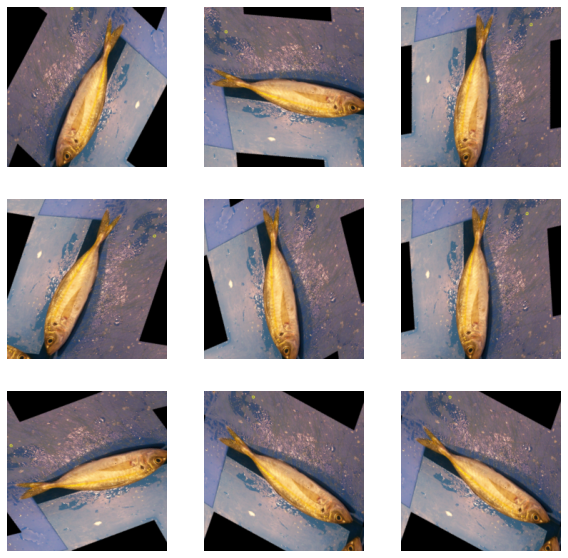

In [93]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [108]:
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                               include_top=False,

                                               weights='imagenet')

83689472/83683744 [==============================] - 2s 0us/step


In [109]:
preprocess_input = tf.keras.applications.xception.preprocess_input

In [110]:
# rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [111]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 7, 7, 2048)


In [112]:
image_batch.shape

TensorShape([32, 224, 224, 3])

In [113]:
base_model.trainable = False

In [114]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_10[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [115]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [116]:
prediction_layer = tf.keras.layers.Dense(9)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 9)


In [117]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [118]:
base_learning_rate = 0.01
optimizer = tf.keras.optimizers.SGD(learning_rate=base_learning_rate, momentum=0.9, decay=0.001)

model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [119]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0   

In [120]:
len(model.trainable_variables)

2

In [121]:


loss0, accuracy0 = model.evaluate(validation_dataset)

42/42 [==============================] - 59s 236ms/step - loss: 6.9790 - accuracy: 0.1399


In [122]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 6.90
initial accuracy: 0.15


In [123]:
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
196/196 [==============================] - 108s 533ms/step - loss: 3.8226 - accuracy: 0.1097 - val_loss: 3.5773 - val_accuracy: 0.1138
Epoch 2/10
196/196 [==============================] - 111s 556ms/step - loss: 3.7217 - accuracy: 0.1100 - val_loss: 3.5950 - val_accuracy: 0.1101
Epoch 3/10
196/196 [==============================] - 115s 578ms/step - loss: 3.7306 - accuracy: 0.1086 - val_loss: 3.5756 - val_accuracy: 0.1101
Epoch 4/10
196/196 [==============================] - 119s 600ms/step - loss: 3.7626 - accuracy: 0.1083 - val_loss: 3.5977 - val_accuracy: 0.1131
Epoch 5/10
196/196 [==============================] - 120s 605ms/step - loss: 3.8096 - accuracy: 0.1095 - val_loss: 3.8095 - val_accuracy: 0.1101
Epoch 6/10
196/196 [==============================] - 117s 589ms/step - loss: 3.7985 - accuracy: 0.1105 - val_loss: 3.7092 - val_accuracy: 0.1057
Epoch 7/10
196/196 [==============================] - 127s 638ms/step - loss: 3.8738 - accuracy: 0.1102 - val_loss: 3.6865 -

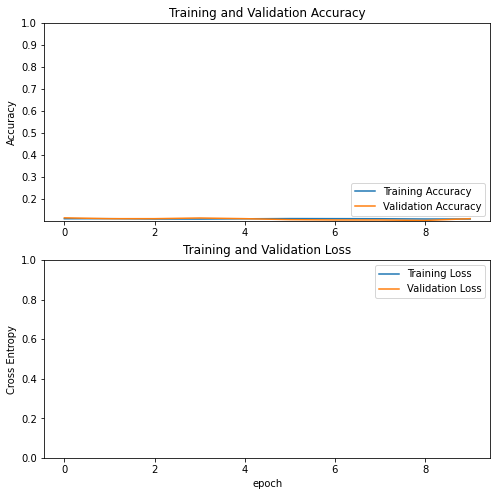

In [124]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()